# Via expressa para ônibus urbano

In [1]:
from _thread import *
from IPython.display import IFrame

import random
import threading
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Configuração para o algoritmo genético

In [2]:
totGeracoes  = 500
tamPopulacao = 50


SelecionartipoBusca = 0  # 1-OneMax outro valor DFS

indCruzamento = 5
CXPB = 0.5
MUTPB = 0.15
PROB_MUTACAO = 0.15

recebeAjuda  = False

#pontuação baixo será eliminada do grafo
removerPior = 0


# Formato Imagens

In [3]:
'''
    Formatos Suportados salvar rotas e mapas: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz 
'''
formato_imgs = 'pdf'

# Configuração da Imagens


In [4]:
'''
    configuração da imagens
'''
edge_color = "#000000"     # cor da aresta
bgcolor    = "#D3D3D3"     # cor do background
node_color = "#9370DB"     # cor da vértice
node_size  = 20            # Tamanho do vértice
fig_height = 20            # altura figura
fig_width  = 20            # largura figura

# Localização para a biblioteca OSMNX gerar o Grafo

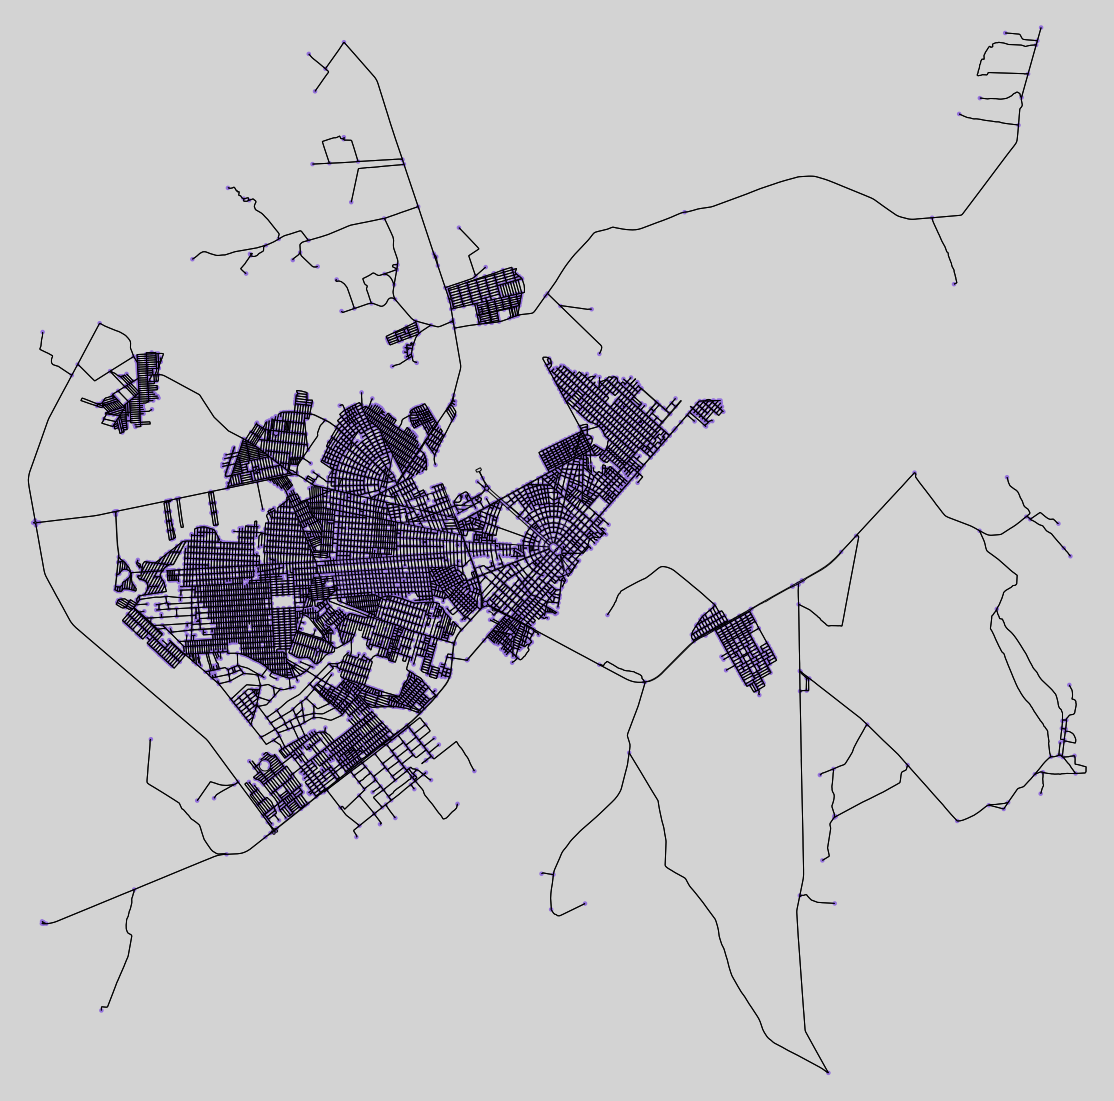

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff92c2c1860>)

In [5]:
place = 'Boa Vista, Roraima, BR'
Raio_distancia = 15000

G = ox.graph_from_address( place, network_type='drive', simplify=True, distance=Raio_distancia )

ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaCompleto", save=True, file_format=formato_imgs)

# Vértice que representa o terminal de ônibus

In [6]:
nodosCentroCivico = (3648084763,3648084762)
nodoAdjTerminal   = (3648084763,3589958315)

# Extrai as informações das via do Grafo G

In [7]:
listaDados = []

dado = G.adj
for i in dado:
    for j in dado[i]:
        for k in dado[i][j]:
            #print()
            #print(dado[i][j][k])
            h = []
            h.append(i)
            h.append(j)
            h.append(dado[i][j][k])
            listaDados.append(h)

# Gera uma lista com as pontuações que cada aresta recebeu dentre as suas características

In [8]:
listaValores = []
valorRuim = -1

for i in listaDados:
    soma = 0
    
    if "highway" in i[2]:
        if i[2]['highway'] == "primary": #ex: avenida venezuela
            soma = 1
        elif i[2]['highway'] == "secondary": #ex: Major Williams
            soma = 1
        elif i[2]['highway'] == "tertiary": #ex: Rua General Penha Brasil
            soma = 1
        else:
            soma = valorRuim
    
    
    listaValores.append(soma)

# Separa os vértices que não conseguiram atingir a pontuação mínima para remoção do Grafo

In [9]:
remover = []

for i in range(len(listaValores)):
    if listaValores[i] <= removerPior:
        remover.append( (listaDados[i][0], listaDados[i][1]))
        
G.remove_edges_from(remover)

# Atualiza a lista de arestas que estão aptas a serem selecionadas

In [10]:
listaValoresNew = []
listaDadosNew = []

for i in range(len(listaDados)):
    if listaValores[i] >= removerPior:
        listaValoresNew.append( listaValores[i] )
        listaDadosNew.append( listaDados[i] )

#remover os dados antigos para devolver memória
listaDados.clear()
listaValores.clear()
print(len(listaValoresNew))

6967


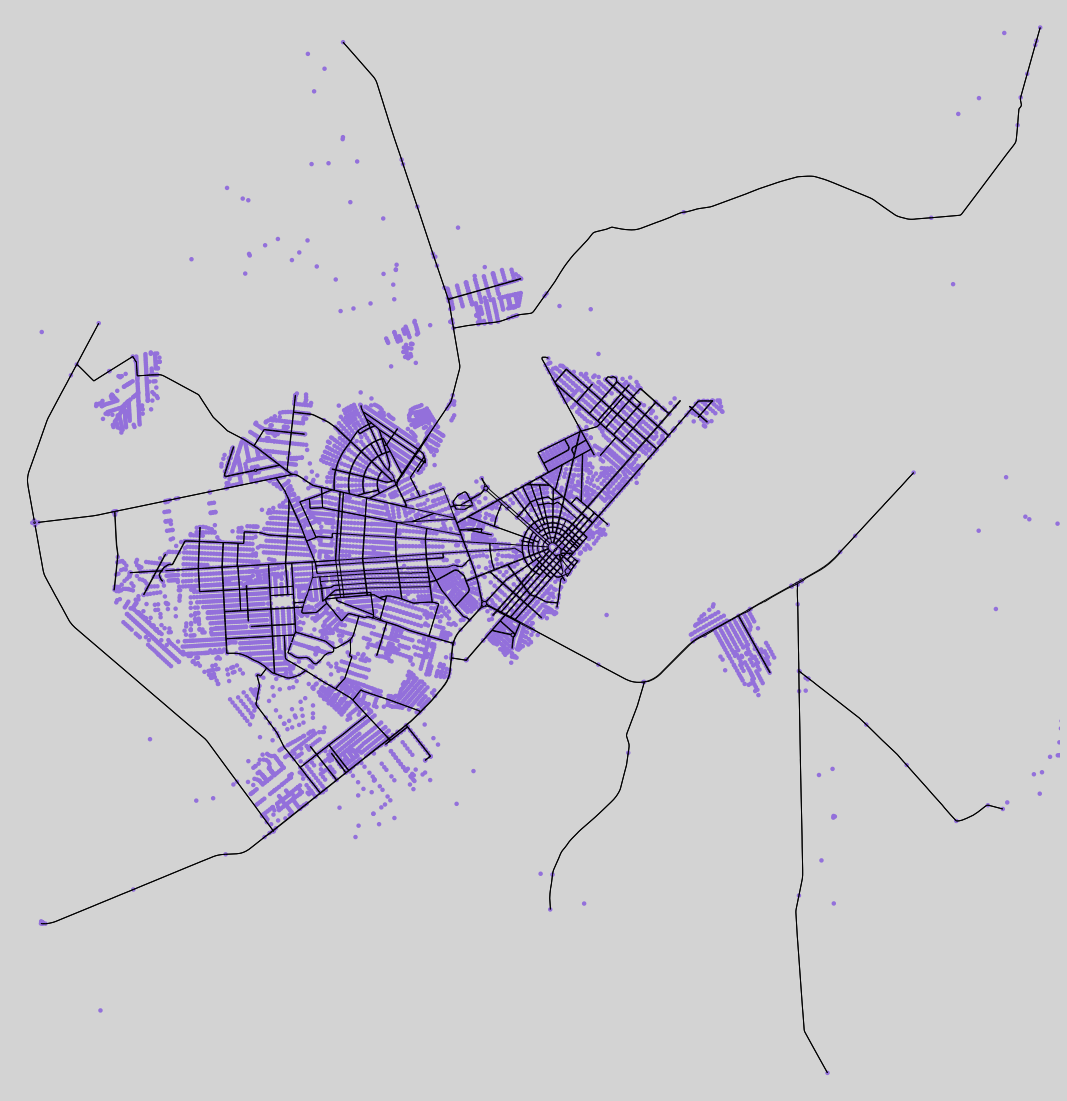

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff931c488d0>)

In [11]:
ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaFiltrado", save=True,  file_format=formato_imgs)

# Lista que receberá os caminhos encontrados pelo AG

In [12]:
listaResultadoDFS = []
tamanhoDosCiclosSalvos = []

# Lista para salvar as informações da evolução do AG para plotagem de gráfico ao final do experimento

In [13]:
PlotMinDados  = []
PlotMeanDados = []
PlotMaxDados  = []

PlotMaioresCiclos = []
PlotMaioresCiclos.append(0)

In [14]:
tamGenes = len(listaValoresNew)

# Busca em profundidade que encontrará os caminhos caso exista

In [15]:
def DFS_BuscaCiclo(grafo, mapa, mapaGrafo, verticeInicial, tamGrafo):
    
    import stack    
    pilha = stack.stack()
    v = verticeInicial
        
    #vetor de marcação de visitados e de elementos que estão na pilha O(1)
    visitados = []
    pilha_rec = []
    
    for i in range(tamGrafo):
        visitados.append(False)
        pilha_rec.append(False)
    
        
    it = -1
    contListaPercorrida = 0
    listaPercorrida = []
    controleMaiorCiclo = PlotMaioresCiclos[-1]
    
    #inicio da BFS
    while True:
        achou_vizinho = False        
        
        listaPercorrida.append(v)
        contListaPercorrida += 1
                
        if not visitados[ mapa[ v ] ]:
            x = mapa[ v ]
            
            pilha.empilhar( x )
            visitados[ x ] = True
            pilha_rec[ x ] = True
            
        for it in grafo[v]:
            
            #se tiver na pilha é porque possue ciclo           
            if it == verticeInicial:
                
                listaArestasCiclo = []
                
                for k in listaPercorrida:
                    if pilha_rec[ mapa[ k ] ] == True:
                        listaArestasCiclo.append( k )
                        
                tamList = len( listaArestasCiclo )
                
                if tamList > controleMaiorCiclo:
                    controleMaiorCiclo = tamList
                    
                    PlotMaioresCiclos.append( controleMaiorCiclo )
                                                        
                    '''
                        Pega o ciclo para salvar
                    '''
                    
                    cicloAtual = []
                    
                    for k in range(1, len(listaArestasCiclo)):
                        cicloAtual.append( (listaArestasCiclo[k-1], listaArestasCiclo[k]) )
                    cicloAtual.append( ( listaArestasCiclo[-1], listaArestasCiclo[0] ) )
                    
                    cicloAtualList = list( cicloAtual )
                    listaResultadoDFS.append( cicloAtualList )
                    tamanhoDosCiclosSalvos.append( tamList )
                    achou_vizinho = False
                    break
                    
            if not visitados[ mapa[ it ] ]:
                achou_vizinho = True
                break
                
        if not achou_vizinho:
            pilha_rec[ pilha.topo() ] = False
                
            pilha.desempilhar()
            
            if pilha.p_vazia():
                break
                
            v = mapaGrafo[ pilha.topo() ]
        
        else:
            v =  it
    
    
    # retorna a quantidade de arestas percorridas
    return contListaPercorrida

# Função que executa um filtro para remover as arestas não selecionadas pelo AG e envia a DFS para validação de rotas

In [16]:
def temCicloDFS(individuo):
    
    G_aux = G.copy()
    
    # ajuda na evolução do onemax
    if recebeAjuda:
        for i in range(100):            
            posicao = random.randint(0,tamGenes-1)
            individuo[posicao] = 1
        
        
                
    #identificador da posicao do nodo centro cívico para verificar se esta ativo
    ja_1 = False
    ja_2 = False
    for i in range(tamGenes):
        if listaDadosNew[i][0] == nodosCentroCivico[0] and listaDadosNew[i][1] == nodosCentroCivico[1]:
            individuo[i] = 1
            ja_1 = True
        if listaDadosNew[i][0] == nodoAdjTerminal[0] and listaDadosNew[i][1] == nodoAdjTerminal[1]:
            individuo[i] = 0
            ja_2 = True
        if ja_1 and ja_2:
            break
            
    
    #lista para remover os nós não selecionados pelo AG
    listaRemover = []            
        
    #Seleção dos nodos não selecionados
    #for i in range(len(individuo)):
    for i in range(tamGenes):
        if individuo[i] == 0:
            listaRemover.append( (listaDadosNew[i][0], listaDadosNew[i][1]) )
            
    #Remove os nodos não selecionados pelo AG
    G_aux.remove_edges_from( listaRemover )
    
    
    
    #listaMapa recebe os valores de [0 a totNodos]
    listaMapa = []
    for i in range(len(G_aux.nodes)):
        listaMapa.append(i)
    
    
    # 215151515 --> 10
    mapa = pd.Series(index=G_aux.nodes, data=listaMapa)
    # 10 --> 215151515
    mapaGrafo = pd.Series(G_aux.nodes)
    
    resposta = DFS_BuscaCiclo(G_aux, mapa, mapaGrafo, nodosCentroCivico[0], len(G_aux.nodes))
    
    if SelecionartipoBusca == 1:
        return np.sum(individuo)
    else:
        return resposta

# DEAP - ONEMAX

In [17]:
log_evolution_GA = []

In [18]:
import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
random.seed(64)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, tamGenes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return temCicloDFS(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=PROB_MUTACAO)
toolbox.register("select", tools.selTournament, tournsize=indCruzamento)

def main():
    pop = toolbox.population(n=tamPopulacao)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=totGeracoes, 
                                   stats=stats, halloffame=hof, verbose=True)
    
    log_evolution_GA.append(log)
    
    return pop, log, hof

if __name__ == "__main__":
    main()

gen	nevals	avg 	min	max
0  	50    	6.56	3  	55 
1  	32    	18.52	3  	67 
2  	22    	31.8 	3  	91 
3  	25    	54.4 	3  	97 
4  	40    	77.44	3  	185
5  	34    	93.68	3  	191
6  	29    	125.92	3  	191
7  	27    	168.16	3  	215
8  	23    	186.56	3  	215
9  	34    	186.16	3  	215
10 	30    	190.96	5  	251
11 	14    	220.2 	125	291
12 	22    	220.2 	7  	291
13 	35    	222.36	3  	295
14 	32    	252.48	9  	299
15 	31    	261.12	7  	299
16 	33    	260.28	5  	299
17 	36    	243.56	3  	301
18 	26    	262.64	3  	301
19 	26    	266.08	7  	301
20 	26    	271.6 	3  	301
21 	25    	278.92	7  	301
22 	21    	263.84	3  	301
23 	26    	263.56	3  	301
24 	26    	274.56	3  	301
25 	31    	290.92	15 	303
26 	25    	285.72	7  	315
27 	28    	261.92	3  	325
28 	29    	274.16	3  	317
29 	27    	302.76	15 	317
30 	27    	266.64	3  	317
31 	36    	287.36	3  	319
32 	27    	287.8 	3  	319
33 	28    	279.32	3  	319
34 	26    	294.36	3  	319
35 	37    	281.8 	3  	319
36 	25    	291.48	17 	319
37 	19    	300.2 	71 

315	28    	381.12	13 	401
316	32    	361.28	3  	401
317	28    	366.4 	3  	401
318	26    	385.36	19 	401
319	25    	370.48	13 	401
320	30    	364.84	3  	401
321	26    	380.08	3  	401
322	34    	347.68	3  	401
323	31    	339.56	3  	401
324	30    	373.96	75 	401
325	32    	357.84	3  	401
326	31    	363.56	3  	401
327	33    	349.12	3  	401
328	28    	358.96	7  	401
329	22    	347.52	3  	401
330	28    	371.52	5  	401
331	31    	336.08	19 	401
332	36    	317.16	3  	401
333	26    	355.48	3  	401
334	29    	365.52	3  	401
335	33    	358.96	3  	401
336	34    	343.12	3  	401
337	28    	357.52	13 	401
338	34    	360.56	13 	401
339	20    	367.52	3  	401
340	32    	333.24	3  	401
341	30    	364.4 	3  	401
342	24    	346.4 	3  	401
343	24    	351.88	3  	401
344	29    	376.72	51 	401
345	25    	375.32	3  	401
346	29    	360.28	3  	401
347	29    	365.52	3  	401
348	29    	350.04	3  	401
349	36    	347.4 	3  	401
350	30    	348.8 	3  	401
351	31    	370.48	5  	401
352	32    	364.72	3  	401
353	27    	3

In [19]:
for dado in log_evolution_GA:
    for dado_i in dado:
        minimo  = int(dado_i['min'])
        media   = int(dado_i['avg'])
        maximo  = int(dado_i['max'])
        
        PlotMinDados.append(minimo)
        PlotMeanDados.append(media)
        PlotMaxDados.append(maximo)

# Gráfico da Evolução do AG dentre as gerações com máximo, média e mínimo

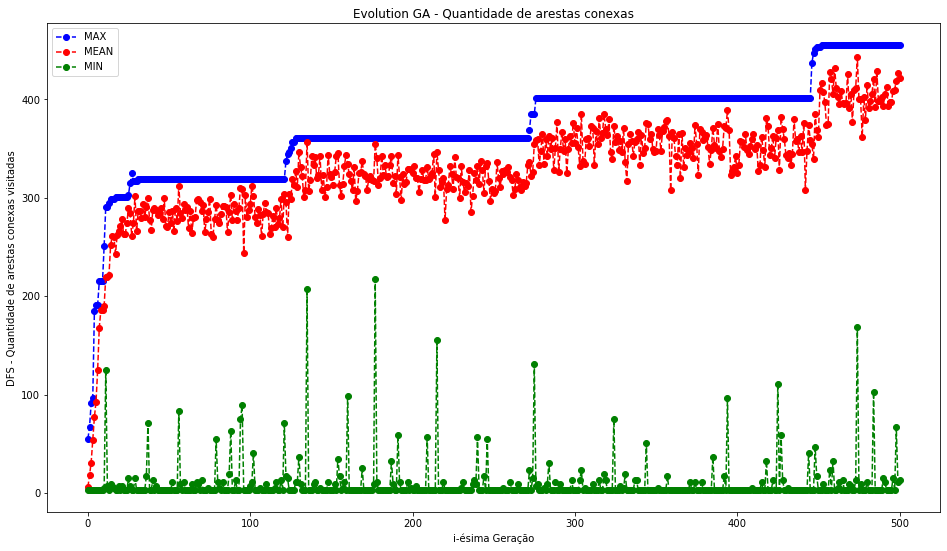

In [20]:
# DFS
plt.figure(figsize=(16,9))
plt.plot(PlotMaxDados, 'ob--' , label='MAX')
plt.plot(PlotMeanDados, 'or--' ,label='MEAN')
plt.plot(PlotMinDados, 'og--',label='MIN')
plt.xlabel('i-ésima Geração')
plt.ylabel('DFS - Quantidade de arestas conexas visitadas')
plt.title('Evolution GA - Quantidade de arestas conexas')
plt.legend(loc='upper left')
plt.savefig("images/graficoEvolucaoDFS.pdf",format=formato_imgs)


# Evolução dos ciclos

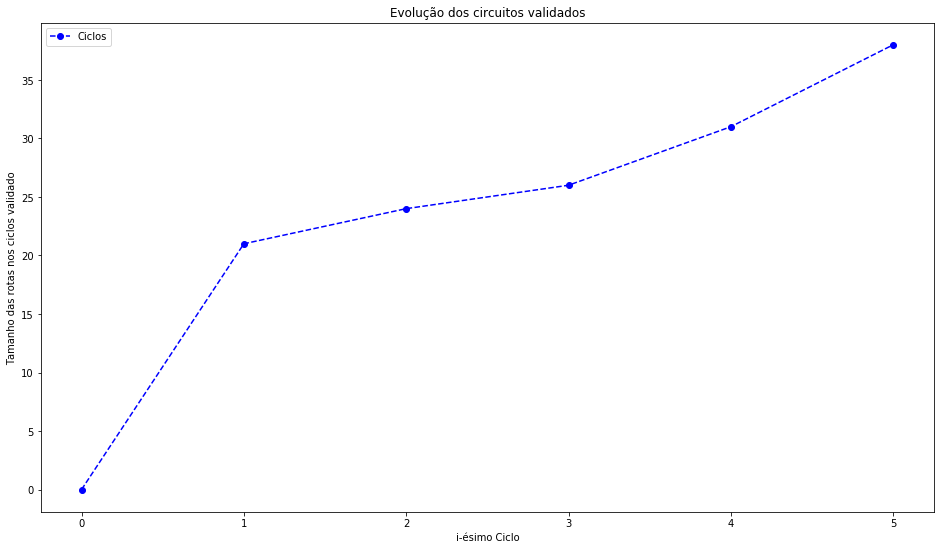

In [21]:
#
# Evolução dos ciclos encontrados
plt.figure(figsize=(16,9))
plt.plot(PlotMaioresCiclos, 'ob--' , label='Ciclos')
plt.xlabel('i-ésimo Ciclo')
plt.ylabel('Tamanho das rotas nos ciclos validado')
plt.title('Evolução dos circuitos validados')
plt.legend(loc='upper left')
plt.savefig("images/1-GraficoTamanhoDosCiclos.pdf",format=formato_imgs)
#plt.show()

# Plotagem das rotas geradas caso tenha encontrado

In [22]:
def salvarRotaTxt(via_vez, rota):
    
    try:
        path = "Rotas/Rota-"+str(via_vez)+".txt"
        arq = open(path, 'w')    
        for linha in rota:
            arq.write(linha+"\n")        
        arq.close()
    except:
        print("Erro salvar rota...")
    
def printFormatNamesStreet( via_vez , qtd_arestas, ruas ):
    
    try:
        contador = 1
        salvarText = []

        # +1 por causa do retorno do ciclo da rota    
        Rota = "Rota "+str(via_vez)+" - "+str(qtd_arestas)+" Arestas:\n"
        print(Rota)
        salvarText.append(Rota)

        for rua in ruas:
            concat = str(rua)
            Rua = ""+str(contador)+"ª - "+concat
            print(Rua)
            salvarText.append(Rua)
            contador = contador + 1

        Rua = ""+str(contador)+"ª - "+ruas[0]
        print(Rua)
        salvarText.append(Rua)

        salvarRotaTxt(via_vez, salvarText)
    except:
        print("Erro printFormatNamesStreet")
        
def printRotaRuas(via_vez, qtd_arestas, rota ):
    
    try:
                
        tamListaDadosNew = len(listaDadosNew)
        tamRotaLista = len(rota)

        ruasRota = []
                    
        for rota_i in range( tamRotaLista ):            
            for lista_i in range(tamListaDadosNew):            
                if( listaDadosNew[lista_i][0] == rota[rota_i][0] and listaDadosNew[lista_i][1] == rota[rota_i][1] ):
                    
                    if 'name' in listaDadosNew[lista_i][2]:
                        rua = listaDadosNew[lista_i][2]['name']

                        if rua not in ruasRota:
                            ruasRota.append(rua)
                                                        
                    else:
                        ruasRota.append("unname")
                  
        
        printFormatNamesStreet(via_vez, qtd_arestas, ruasRota )
        print("\n\n")
    
    except:
        print("Erro print ruas...")

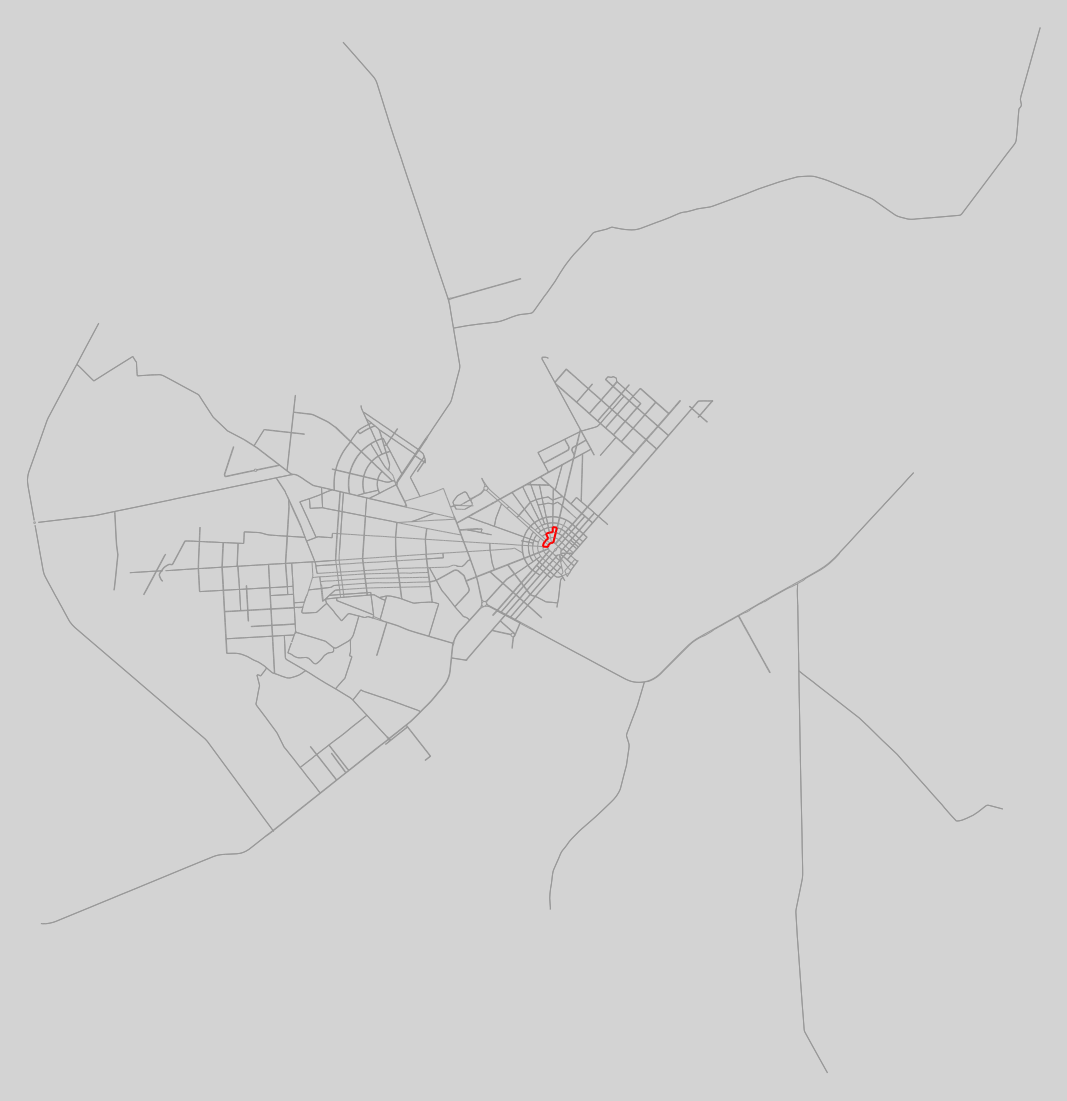



Rota 1 - 21 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Alfredo Cruz
8ª - Rua Alferes Paulo Saldanha
9ª - Rua Barão do Rio Branco
10ª - Avenida Capitão Júlio Bezerra
11ª - Avenida Amazonas





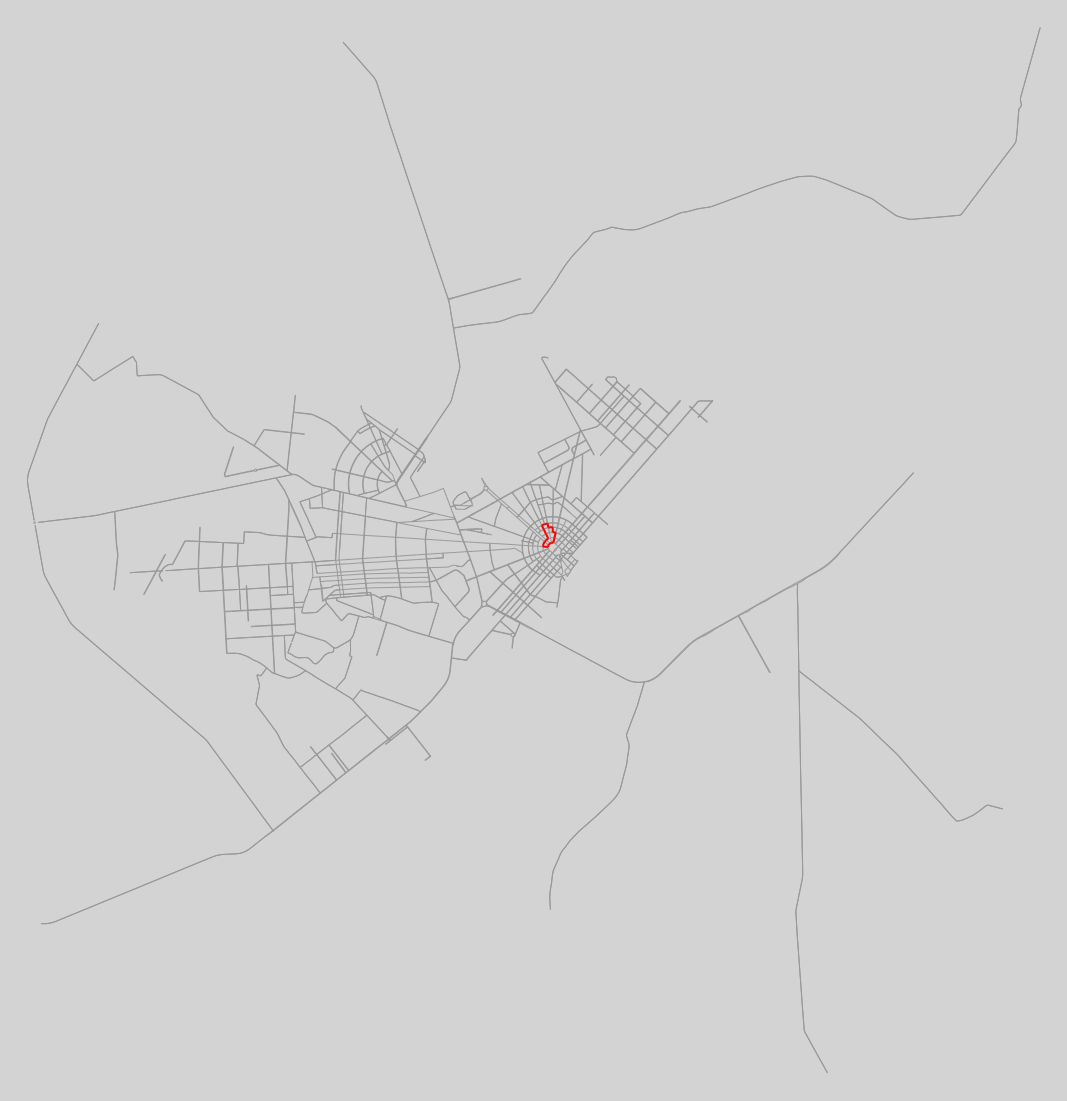



Rota 2 - 24 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Coronel Mota
8ª - Rua Professor Agnelo Bitencourt
9ª - Rua Barão do Rio Branco
10ª - Rua Alferes Paulo Saldanha
11ª - Rua Alfredo Cruz
12ª - Avenida Capitão Júlio Bezerra
13ª - Avenida Amazonas





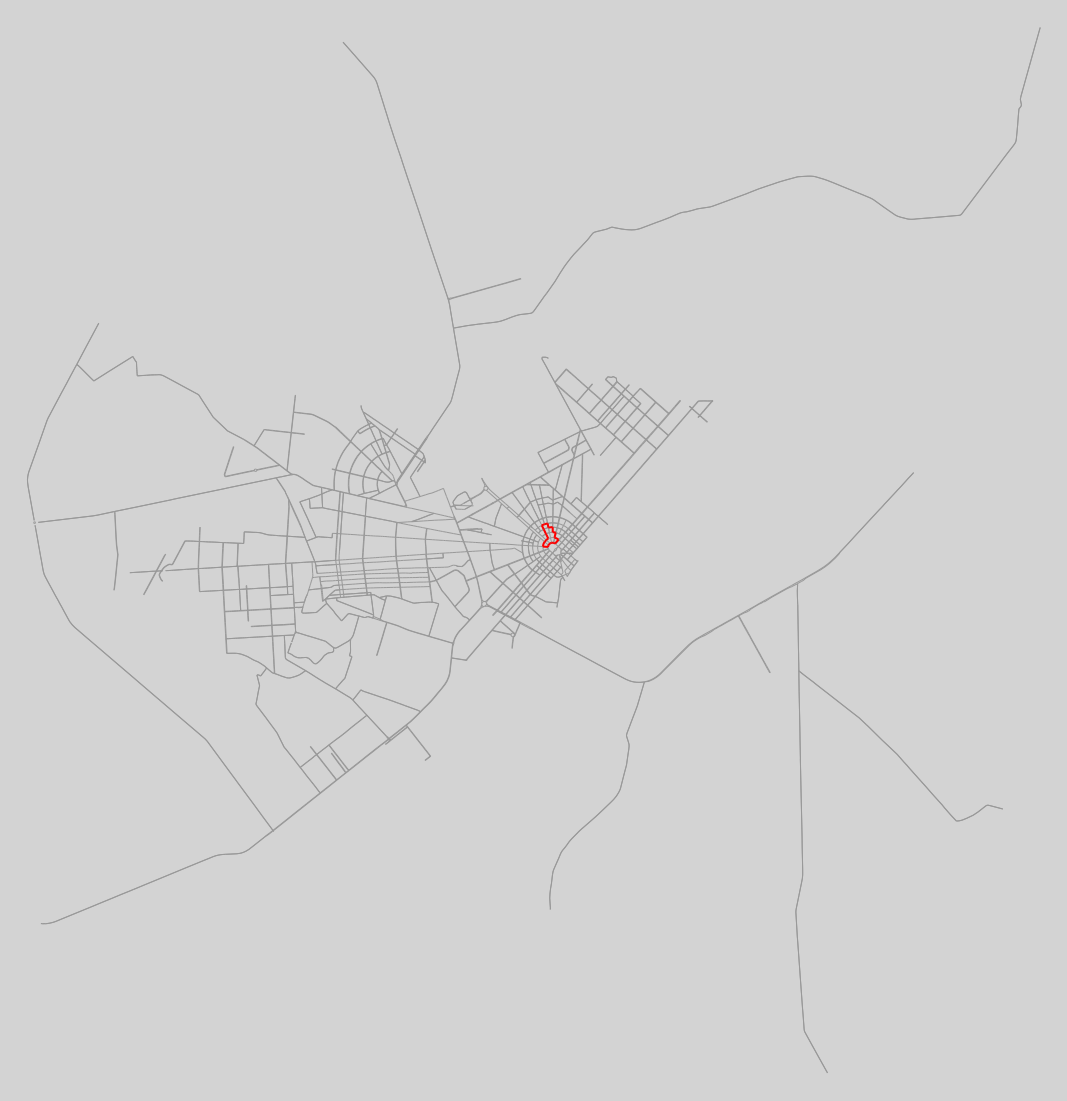



Rota 3 - 26 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Coronel Mota
8ª - Rua Professor Agnelo Bitencourt
9ª - Rua Barão do Rio Branco
10ª - Rua Alferes Paulo Saldanha
11ª - Rua Alfredo Cruz
12ª - Avenida Capitão Júlio Bezerra
13ª - Avenida Ville Roy
14ª - Avenida Amazonas





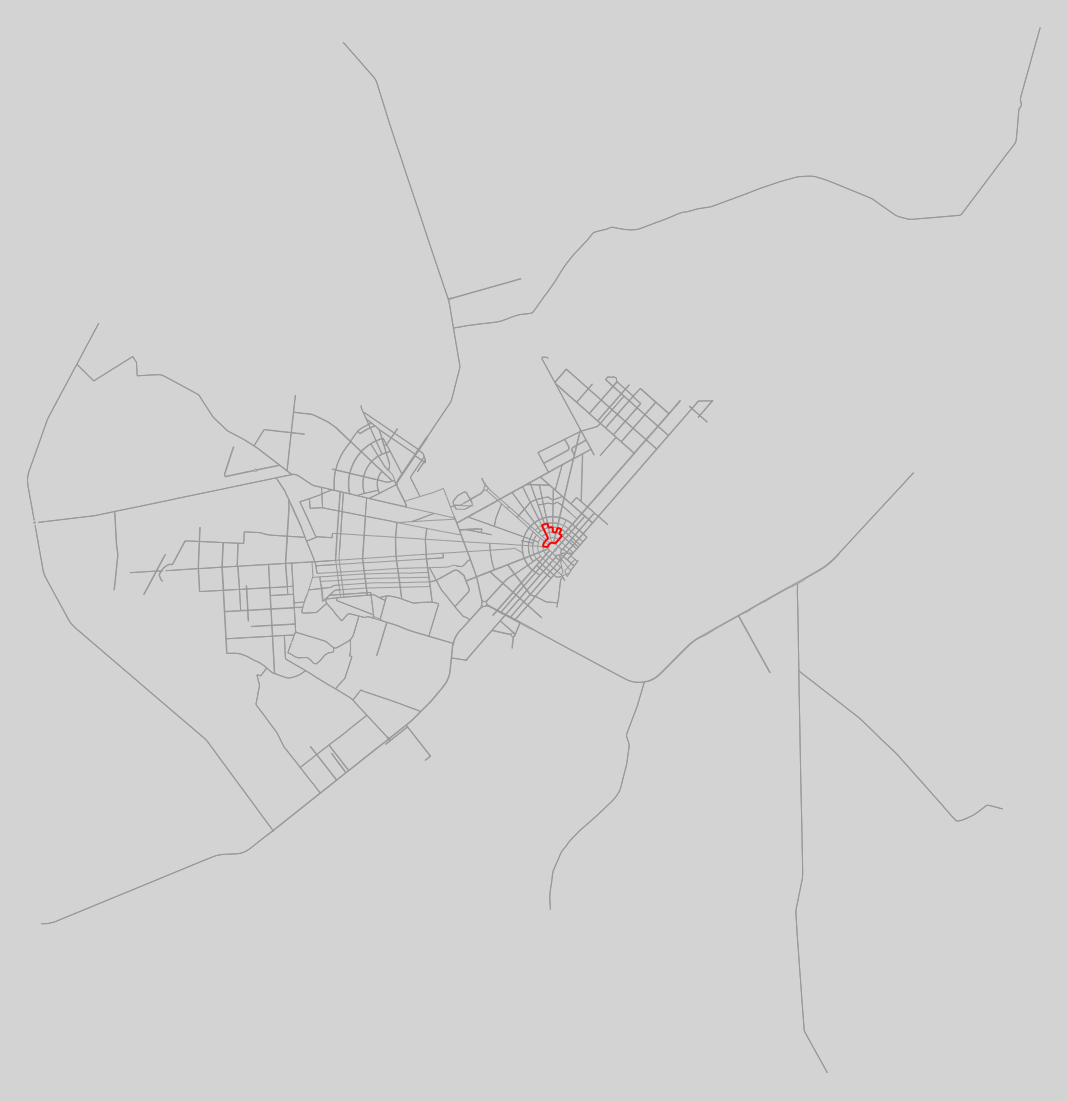



Rota 4 - 31 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Coronel Mota
8ª - Rua Professor Agnelo Bitencourt
9ª - Rua Barão do Rio Branco
10ª - Rua Alferes Paulo Saldanha
11ª - Rua Alfredo Cruz
12ª - Avenida Capitão Júlio Bezerra
13ª - Rua Rocha Leal
14ª - Avenida Ville Roy
15ª - Avenida Amazonas





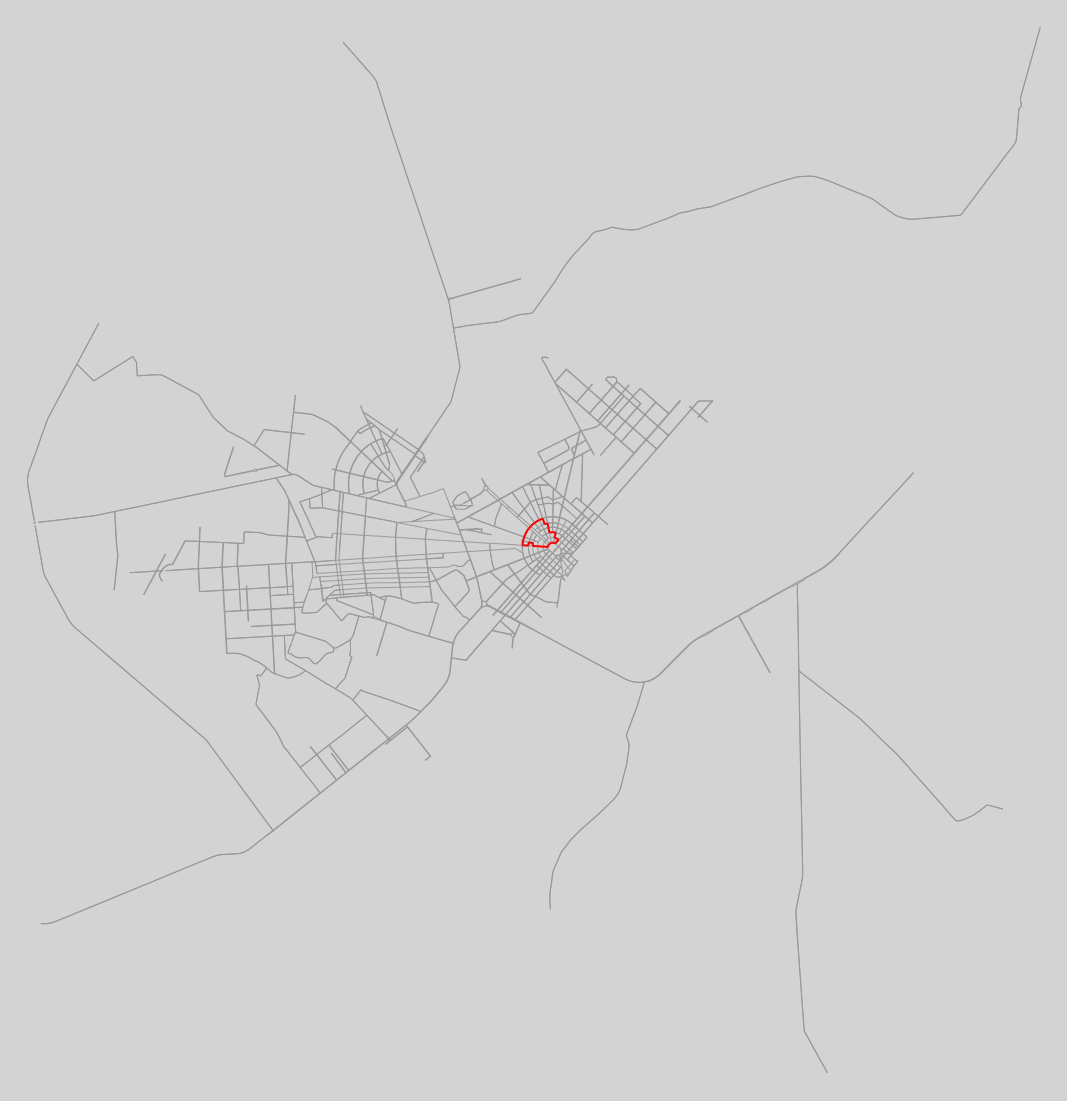



Rota 5 - 38 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Ajuricaba
4ª - Rua Dom Pedro I
5ª - Rua Cerejo Cruz
6ª - Avenida Terêncio Lima
7ª - Avenida Major Williams
8ª - Rua Valério Magalhães
9ª - Rua Coronel Mota
10ª - Rua Professor Agnelo Bitencourt
11ª - Rua Alfredo Cruz
12ª - Avenida Capitão Júlio Bezerra
13ª - Rua Coronel Pinto
14ª - Avenida Ville Roy
15ª - Avenida Amazonas





In [23]:
removerNodosFinal = []
cont=1
contador = 1
if len(listaResultadoDFS) > 0:
    for cadaCicloEncontrado in range(len(listaResultadoDFS)):
        
        name = "1-Rota-"+ str(contador)

        arestas_sel = listaResultadoDFS[cadaCicloEncontrado]

        path = [ (u,v) for (u,v, attr) in G.edges(data=True) if (u,v) in arestas_sel]

        ox.plot.plot_graph_routes(G, path, show=True, fig_height=fig_height, fig_width=fig_width, bgcolor=bgcolor, route_alpha=1, route_linewidth=2, node_size=0 , orig_dest_node_alpha=0, filename=name, save=True,  file_format=formato_imgs )
        print("\n")

        printRotaRuas( contador, PlotMaioresCiclos[contador] , listaResultadoDFS[cadaCicloEncontrado] )
        contador = contador + 1
        
else:
    print("Infelizmente não foi possivel encontrar uma rota....")

# FIMMM --- Obrigado